# 第6回講義 演習

In [1]:
%matplotlib inline
import copy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.datasets import cifar10

rng = np.random.RandomState(1234)
random_state = 42

In [2]:
cd ../userspace/MyChap07/material/

/root/userspace/MyChap07/material


In [3]:
from logging import getLogger, StreamHandler, DEBUG, FileHandler, Formatter
logger = getLogger(__name__)
sthandler = StreamHandler()
sthandler.setLevel(DEBUG)

filehandler = FileHandler("model_training.log")
filehandler.setLevel(DEBUG)

formatter = Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
filehandler.setFormatter(formatter)
sthandler.setFormatter(formatter)

logger.addHandler(sthandler)
logger.addHandler(filehandler)
logger.setLevel(DEBUG)
logger.propagate = False

logger.debug('hello')

2019-06-03 22:40:11,172:18:DEBUG:hello


## 1. CIFAR-10データセットの読み込みと可視化

In [4]:
def gcn(x):
    mean = np.mean(x, axis=(1, 2, 3), keepdims=True)
    std = np.std(x, axis=(1, 2, 3), keepdims=True)
    return (x - mean)/std

In [5]:
# 可視化用に画像を[0,1]にする&次元を変更
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

In [6]:
# 可視化用に各画像ごとに[0,1]にする(ZCAの結果を見やすくするため)&次元を変更
def deprocess_each_img(x):
    _min = np.min(x, axis=(1, 2, 3), keepdims=True)
    _max = np.max(x, axis=(1, 2, 3), keepdims=True)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

In [7]:
class ZCAWhitening:
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, x):
        x = x.reshape(x.shape[0], -1)
        self.mean = np.mean(x, axis=0)
        x -= self.mean
        cov_matrix = np.dot(x.T, x) / x.shape[0]
        A, d, _ = np.linalg.svd(cov_matrix)
        self.ZCA_matrix = np.dot(np.dot(A, np.diag(1. / np.sqrt(d + self.epsilon))), A.T)

    def transform(self, x):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        x -= self.mean
        x = np.dot(x, self.ZCA_matrix.T)
        return x.reshape(shape)

## 7. 実験

これまで扱ってきたTensorflowの実装では比較的低レベルなAPIを使用してきました。それは本講義ではアルゴリズムの実装にフォーカスするためです。

しかしながら、実際にビジネスや研究で利用するときにはプリミティブな実装を一から書くのは手間になる場合もあります。そのような課題を解決するニーズに答え、Tensorflowには高レベルなAPIも用意されています。その一つに`tf.layers`というAPIがあります。

ここでは、`tf.layers`を使って、課題5の畳み込みニューラルネットワークの実装を行ってみましょう。


なお、このような高レベルなAPIは簡単に実装できる反面、実装の柔軟性が落ちるという欠点もあります。場合によって使い分ける必要があります。

`tf.layers`で使えるモジュールは以下のページで確認できます。

[Module: tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers)

### データの読み込み

In [8]:
import numpy as np
import pandas as pd

def load_cifar10():
    
    # 学習データ
    x_train = np.load('/root/userspace/public/chap07/data/x_train.npy')
    t_train = np.load('/root/userspace/public/chap07/data/t_train.npy')

    # テストデータ
    x_test = np.load('/root/userspace/public/chap07/data/x_test.npy')
    
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    t_train = np.eye(10)[t_train.astype('int32').flatten()]
    
    return (x_train, x_test, t_train)

In [9]:
x_train, x_test, t_train = load_cifar10()
x_train, x_valid, t_train, t_valid = train_test_split(x_train, t_train, test_size=0.1, random_state=random_state)
zca = ZCAWhitening()
zca.fit(x_train)
x_train_zca = zca.transform(gcn(x_train))
t_train_zca = t_train[:]
x_valid_zca = zca.transform(gcn(x_valid))
t_valid_zca = t_valid[:]
x_test_zca = zca.transform(gcn(x_test))

In [10]:
x_train_all = np.r_[x_train_zca]
t_train_all = np.r_[t_train_zca]

x_valid_all = np.r_[x_valid_zca]
t_valid_all = np.r_[t_valid_zca]

In [11]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
#         _, h, w, c = self.X_train.shape
#         _, class_num = self.y_train.shape
        X_train_ = copy.deepcopy(self.X_train[batch_ids])
        if self.datagen:
            for i in range(self.batch_size*2):
                X_train_[i] = self.datagen.random_transform(X_train_[i])
        X1 = X_train_[:self.batch_size]
        X2 = X_train_[self.batch_size:]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [12]:
class random_augumentation():
    def __init__(self, h_flip_p = 0.5, r_erasing_p = 0.5, cropping_p = 0.5, rotation_p=0.5):
        self.h_flip_p =h_flip_p
        self.r_erasing_p = r_erasing_p
        self.cropping_p = cropping_p
        self.rotation_p = rotation_p
        
    def random_transform(self, x):
        ''' x.shape = [a, a, 3]
        '''
        img = x
        if np.random.uniform(0,1) < self.h_flip_p:
            img = self._horizontal_flip(img)
        
        if np.random.uniform(0,1) < self.r_erasing_p:
            img = self._erasing(img)
            
        if np.random.uniform(0,1) < self.cropping_p:
            img = self._cropping(img)
            
        if np.random.uniform(0,1) < self.rotation_p:
            img = self._rotation(img)
            
        return img
        
    def _horizontal_flip(self, x):
        ''' x.shape = [a, a, 3]
        '''
        return x[:, ::-1, :]
        
    def _erasing(self, img, s_l = 0.02, s_h = 0.2, r1 = 0.3, r2 = 1. / 0.3):
        H = img.shape[0]
        W = img.shape[1]
        S = H * W
        while True:
            S_e = S * np.random.uniform(low=s_l, high=s_h)
            r_e = np.random.uniform(low=r1, high=r2)

            H_e = np.sqrt(S_e * r_e)
            W_e = np.sqrt(S_e / r_e)

            x_e = np.random.randint(0, W)
            y_e = np.random.randint(0, H)

            if x_e + W_e <= W and y_e + H_e <= H:
                img_erased = np.copy(img)
                img_erased[y_e:int(y_e + H_e + 1), x_e:int(x_e + W_e + 1), :] = np.random.uniform(0, 1)
                return img_erased
            
    def _cropping(self, img, crop_size=4):
        H, W, _ = img.shape
        padded = np.pad(img, ((crop_size, crop_size), (crop_size, crop_size), (0, 0)), mode='constant')
        c = rng.randint(8, size=2)
        cropped = padded[c[0]:(c[0]+H), c[1]:(c[1]+W), :]
        return cropped
    
    def _rotation(self, img, angle_range=(-10, 10)):
        H, W, _ = img.shape
        angle = np.random.randint(*angle_range)
        img = rotate(img, angle)
        c = [0, 0]
        if img.shape[0] > H:
            c[0] = rng.randint(img.shape[0] - H)
        if img.shape[0] > W:
            c[1] = rng.randint(img.shape[1] - W)
        img = img[c[0]:(c[0]+H), c[1]:(c[1]+W), :]
        return img

In [13]:
random_aug = random_augumentation()

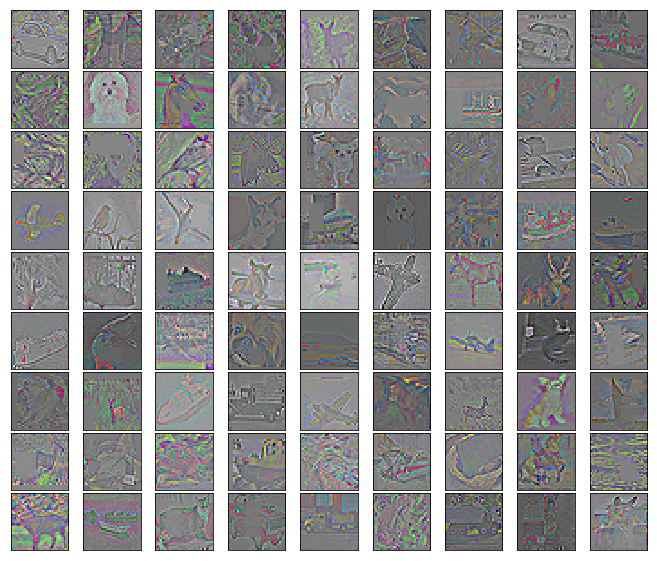

In [18]:
# data augumentationの結果を確認する
random_aug = random_augumentation()
training_generator = MixupGenerator(x_train_all, t_train_all, datagen=random_aug, batch_size=100)()
x_, t_ = next(training_generator)

x_ = deprocess_each_img(x_)
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_[i])
    
plt.show()

### 7.1. ネットワークの実装

In [19]:
# tf.log(0)によるnanを防ぐ
def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

In [20]:
tf.reset_default_graph()

is_training = tf.placeholder(tf.bool, shape=()) # batch normalizationのために定義
learning_rate = tf.placeholder(tf.float32, shape=()) # 学習率を動的に変更
x = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
t = tf.placeholder(tf.float32, [None, 10])

### ネットワーク ###
h = tf.layers.Conv2D(filters=64, kernel_size= [3, 3], padding="same")(x) # 32x32x64
h = tf.layers.Conv2D(filters=64, kernel_size= [3, 3], padding="same")(h) # 32x32x64
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
# h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 16x16x64

h = tf.layers.Conv2D(filters=64, kernel_size= [3, 3], padding="same")(h) # 32x32x64
h = tf.layers.Conv2D(filters=64, kernel_size= [3, 3], padding="same")(h) # 32x32x64
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 16x16x64

h = tf.layers.Conv2D(filters=128, kernel_size= [3, 3], padding="same")(h) # 16x16x128
h = tf.layers.Conv2D(filters=128, kernel_size= [3, 3], padding="same")(h) # 16x16x128
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)

h = tf.layers.Conv2D(filters=128, kernel_size= [3, 3], padding="same")(h) # 16x16x128
h = tf.layers.Conv2D(filters=128, kernel_size= [3, 3], padding="same")(h) # 16x16x128
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 8x8x128

h = tf.layers.Conv2D(filters=256, kernel_size= [3, 3], padding="same")(h) #8x8x256
h = tf.layers.Conv2D(filters=256, kernel_size= [3, 3], padding="same")(h) #8x8x256
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)

h = tf.layers.Conv2D(filters=256, kernel_size= [3, 3], padding="same")(h) #8x8x256
h = tf.layers.Conv2D(filters=256, kernel_size= [3, 3], padding="same")(h) #8x8x256
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 4x4x256

h = tf.nn.avg_pool(h, ksize=[1,4,4,1], strides=[1,1,1,1], padding="VALID")
h = tf.layers.Flatten()(h)
h = tf.layers.Dense(units=256, activation=tf.nn.relu)(h)
y = tf.layers.Dense(units=10, activation=tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis=1))

# batch normalizationのために記述しています。
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(cost)

### 7.2. 学習

In [21]:
n_epochs = 300
batch_size = 50
lr = 0.01
n_batches = x_train.shape[0]//batch_size
n_batches_val = x_valid.shape[0]//batch_size
n_batches_test = x_test_zca.shape[0]//batch_size

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [22]:
for epoch in range(n_epochs):
    cost_train = []
    training_generator = MixupGenerator(x_train_all, t_train_all, datagen=random_aug, batch_size=batch_size)()
    for batch in range(n_batches):
        x_, t_ = next(training_generator)
        _, cost_ = sess.run([optimizer, cost], feed_dict={x: x_, t: t_, is_training:True, learning_rate: lr})
        cost_train.append(cost_)
    cost_train = np.array(cost_train).mean()
        
    cost_valid = []
    y_pred = []
    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        y_pred_, cost_valid_ = sess.run([y, cost], feed_dict={x: x_valid_all[start:end], t: t_valid_all[start:end], is_training:False})
        cost_valid.append(cost_valid_)
        y_pred.append(y_pred_)
    cost_valid = np.array(cost_valid).mean()
    y_pred = np.concatenate(y_pred, axis=0)
    
    logger.info('EPOCH: {}, Train Cost: {:.3f}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
                        epoch, np.array(cost_train).mean(), cost_valid,
                        accuracy_score(t_valid_all.argmax(axis=1), y_pred.argmax(axis=1))
                        ))

2019-06-03 22:43:23,776:23:INFO:EPOCH: 0, Train Cost: 1.583, Valid Cost: 1.337, Valid Accuracy: 0.530
2019-06-03 22:44:44,397:23:INFO:EPOCH: 1, Train Cost: 1.277, Valid Cost: 1.013, Valid Accuracy: 0.653
2019-06-03 22:46:04,904:23:INFO:EPOCH: 2, Train Cost: 1.140, Valid Cost: 0.809, Valid Accuracy: 0.729
2019-06-03 22:47:25,180:23:INFO:EPOCH: 3, Train Cost: 1.069, Valid Cost: 0.829, Valid Accuracy: 0.722
2019-06-03 22:48:45,631:23:INFO:EPOCH: 4, Train Cost: 1.008, Valid Cost: 0.676, Valid Accuracy: 0.770
2019-06-03 22:50:05,811:23:INFO:EPOCH: 5, Train Cost: 0.978, Valid Cost: 0.704, Valid Accuracy: 0.765
2019-06-03 22:51:26,514:23:INFO:EPOCH: 6, Train Cost: 0.937, Valid Cost: 0.694, Valid Accuracy: 0.764
2019-06-03 22:52:46,938:23:INFO:EPOCH: 7, Train Cost: 0.916, Valid Cost: 0.651, Valid Accuracy: 0.778
2019-06-03 22:54:07,383:23:INFO:EPOCH: 8, Train Cost: 0.894, Valid Cost: 0.616, Valid Accuracy: 0.795
2019-06-03 22:55:27,714:23:INFO:EPOCH: 9, Train Cost: 0.877, Valid Cost: 0.612, Va

2019-06-04 02:18:04,298:23:INFO:EPOCH: 160, Train Cost: 0.497, Valid Cost: 0.259, Valid Accuracy: 0.923
2019-06-04 02:19:24,847:23:INFO:EPOCH: 161, Train Cost: 0.491, Valid Cost: 0.268, Valid Accuracy: 0.924
2019-06-04 02:20:45,277:23:INFO:EPOCH: 162, Train Cost: 0.497, Valid Cost: 0.311, Valid Accuracy: 0.916
2019-06-04 02:22:05,742:23:INFO:EPOCH: 163, Train Cost: 0.492, Valid Cost: 0.296, Valid Accuracy: 0.917
2019-06-04 02:23:26,046:23:INFO:EPOCH: 164, Train Cost: 0.493, Valid Cost: 0.260, Valid Accuracy: 0.924
2019-06-04 02:24:46,713:23:INFO:EPOCH: 165, Train Cost: 0.496, Valid Cost: 0.302, Valid Accuracy: 0.917
2019-06-04 02:26:07,246:23:INFO:EPOCH: 166, Train Cost: 0.492, Valid Cost: 0.289, Valid Accuracy: 0.919
2019-06-04 02:27:27,592:23:INFO:EPOCH: 167, Train Cost: 0.495, Valid Cost: 0.310, Valid Accuracy: 0.917
2019-06-04 02:28:48,023:23:INFO:EPOCH: 168, Train Cost: 0.493, Valid Cost: 0.261, Valid Accuracy: 0.923
2019-06-04 02:30:08,649:23:INFO:EPOCH: 169, Train Cost: 0.498, V

In [25]:
saver = tf.train.Saver()
saver.save(sess, '../model/model_0604.ckpt')

'../model/model_0604.ckpt'

In [26]:
saver = tf.train.Saver()

sess = tf.Session()
saver.restore(sess, '../model/model_0604.ckpt')

INFO:tensorflow:Restoring parameters from ../model/model_0604.ckpt


In [28]:
# 提出用のコード
y_pred = []
for batch in range(n_batches_val):
    start = batch * batch_size
    end = start + batch_size
    y_pred_ = sess.run(y, feed_dict={x: x_test_zca[start:end], is_training:False})
    y_pred.append(y_pred_)
y_pred = np.concatenate(y_pred, axis=0)
y_pred = y_pred.argmax(axis=1)
submission = pd.Series(y_pred, name='label')
submission.to_csv('/root/userspace/submission_pred.csv', header=True, index_label='id')

In [27]:
y_pred = []
cost_valid = []
epoch = 0
for batch in range(n_batches_val):
    start = batch * batch_size
    end = start + batch_size
    y_pred_, cost_valid_ = sess.run([y, cost], feed_dict={x: x_valid_all[start:end], t: t_valid_all[start:end], is_training:False})
    cost_valid.append(cost_valid_)
    y_pred.append(y_pred_)
cost_valid = np.array(cost_valid).mean()
y_pred = np.concatenate(y_pred, axis=0)

logger.info('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
                    epoch, cost_valid, accuracy_score(t_valid_all.argmax(axis=1), y_pred.argmax(axis=1))
                    ))

2019-06-04 05:29:21,327:14:INFO:EPOCH: 0, Valid Cost: 0.247, Valid Accuracy: 0.932
